In this exercise we will plot all the data locations available for a given day in the *latest* directory of the global product (INSITU_GLO_NRT_OBSERVATIONS_013_030) directory. We assume the data have been downloaded in the following directory:

In [107]:
datadir = "~/CMEMS_INSTAC/INSITU_GLO_NRT_OBSERVATIONS_013_030/latest/20151201/"

In [108]:
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import os
import netCDF4
import numpy as np

# File reading

We create a list of the files available in the directory:

In [109]:
datadir = os.path.expanduser(datadir)
filelist = sorted(glob.glob(datadir + '*nc'))
nfiles = len(filelist)
print("Number of files = %u" % (nfiles))

Number of files = 4839


Now we can loop on the files (just the first 10) to check if it's okay:

In [110]:
for datafiles in filelist[0:10]:
    print os.path.basename(datafiles)

AR_LATEST_PR_CT_MYO_AR_ITP_82_20151201.nc
AR_LATEST_PR_CT_MYO_AR_ITP_83_20151201.nc
AR_LATEST_PR_CT_MYO_AR_ITP_89_20151201.nc
AR_LATEST_PR_CT_MYO_AR_ITP_91_20151201.nc
AR_LATEST_PR_CT_MYO_AR_ITP_92_20151201.nc
AR_LATEST_PR_CT_MYO_AR_ITP_93_20151201.nc
AR_LATEST_TS_MO_MYO_AR_Blakksnes_20151201.nc
AR_LATEST_TS_MO_MYO_AR_Drangsnes_20151201.nc
AR_LATEST_TS_MO_MYO_AR_Gardskagadufl_20151201.nc
AR_LATEST_TS_MO_MYO_AR_Grimsey_20151201.nc


# Basic plot

We read the coordinate variables from the file and plot them on the map.

Then we loop on the files:

In [111]:
lon = np.zeros(nfiles)
lat = np.zeros(nfiles)
for count, datafiles in enumerate(filelist):
    with netCDF4.Dataset(datafiles) as nc:
        lon[count] = np.nanmean(nc.variables['LONGITUDE'][:])
        lat[count] = np.nanmean(nc.variables['LATITUDE'][:])

We also mask the bad values of coordinates:

In [112]:
lon = np.ma.masked_outside(lon, -180., 360.)
lat = np.ma.masked_outside(lat, -90., 90.)

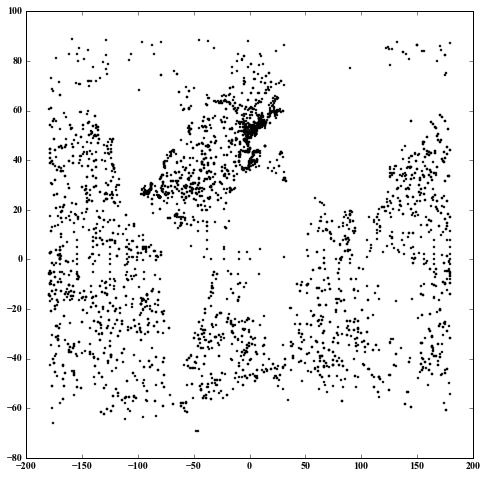

In [113]:
fig = plt.figure(figsize=(8, 8))
plt.plot(lon, lat, 'ko', markersize=2)
plt.show()

# Improved plot

A projection is created, so we have access to a coastline, land mask, ...

In [114]:
from mpl_toolkits.basemap import Basemap
m = Basemap(projection='moll', lon_0=0, resolution='c')
lon_p, lat_p = m(lon, lat)

In [115]:
import matplotlib
font = {'family' : 'serif',
        'size'   : 16}

matplotlib.rc('font', **font)

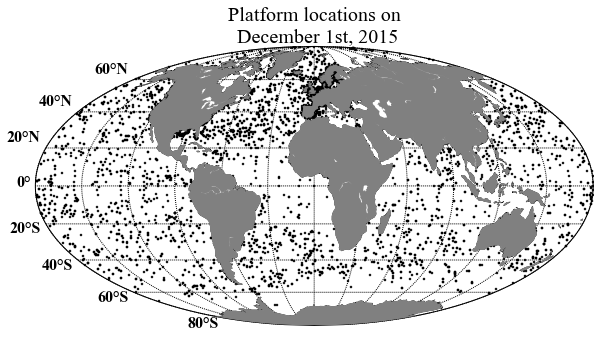

In [116]:
fig = plt.figure(figsize=(10,8))
m.plot(lon_p, lat_p, 'ko', markersize=2)
m.drawparallels(np.arange(-80, 80., 20.),labels=[True,False,False,True], zorder=2)
m.drawmeridians(np.arange(-180, 180., 30.), zorder=2)
m.fillcontinents(color='gray', zorder=3)
m.drawcoastlines(linewidth=0.5)
plt.title('Platform locations on\n December 1st, 2015', fontsize=20)

plt.show()

It is interesting to see the highly variable coverage.<br/> 
For example near the Equator in the Atlantic Ocean, the coverage is very low.

# Plot by platform

The idea is to have a different color depending on the platform type:
* drifting buoys,
* gliders, 
* moorings...
To do so, we will create a list of files for each parameter.<br/>
There is an extensive description of all the data types in this [document](http://marine.copernicus.eu/documents/PUM/CMEMS-INS-PUM-013.pdf).

In [117]:
datatypelist = ('BA', 'BO', 'CT', 'DB', 'DC', 'FB', 'GL', 'MO', 'ML', 'PF', 'RF', 'TE', 'TS', 'XB')
for datatype in datatypelist:
    filelist = sorted(glob.glob(datadir + '*LATEST_*_' + datatype + '*nc'))
    nfiles = len(filelist)
    print("Number of files of type %s = %u" % (datatype, nfiles))

Number of files of type BA = 6
Number of files of type BO = 1
Number of files of type CT = 6
Number of files of type DB = 1417
Number of files of type DC = 1032
Number of files of type FB = 6
Number of files of type GL = 4
Number of files of type MO = 700
Number of files of type ML = 2
Number of files of type PF = 1346
Number of files of type RF = 89
Number of files of type TE = 218
Number of files of type TS = 14
Number of files of type XB = 1


We see that some data types are not often present in the list, so we will only take those with at least 50 data files.<br>
We create a dictionnary with the abbreviation and the corresponding data types:

In [118]:
datatypename = {'DB': 'Drifting buoys', 'DC': 'Drifting buoy reporting calculated sea water current',
                'MO': 'Fixed buoys or mooring time series', 'PF': 'Profiling floats vertical profiles',
                'RF': 'River flows', 'TE': 'TESAC messages on GTS'}
datatypename.keys()

['MO', 'DB', 'DC', 'RF', 'PF', 'TE']

We create a list of colors for the plot:

In [120]:
colorlist = ['r', 'g', 'b', 'y', 'm', 'c', 'k']

In [121]:
m = Basemap(projection='robin', lat_0=0, lon_0=0., resolution='l')

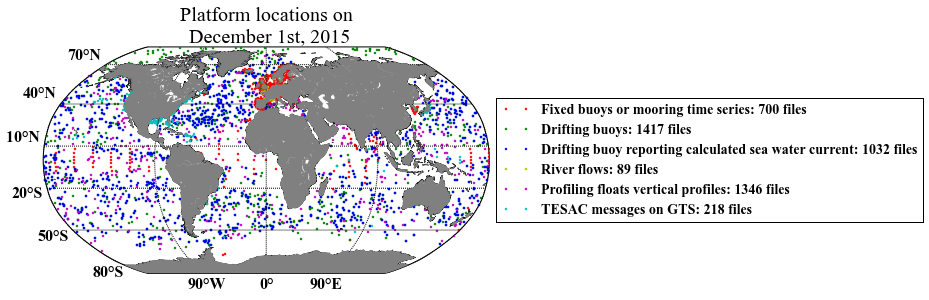

In [122]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111)
for ntype, datatype in enumerate(datatypename.keys()):
    filelist = sorted(glob.glob(datadir + '*LATEST_*_' + datatype + '*nc'))
    nfiles = len(filelist)
    lon = np.zeros(nfiles)
    lat = np.zeros(nfiles)
    for count, datafiles in enumerate(filelist):
        with netCDF4.Dataset(datafiles) as nc:
            lon[count] = np.nanmean(nc.variables['LONGITUDE'][:])
            lat[count] = np.nanmean(nc.variables['LATITUDE'][:])
    lon_p, lat_p = m(lon, lat)
    m.plot(lon_p, lat_p, 'o', markerfacecolor=colorlist[ntype], markeredgecolor=colorlist[ntype],
           markersize=2, label=datatypename[datatype] + ': ' + str(nfiles) + ' files')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=14)

m.drawparallels(np.arange(-80, 80., 30.),labels=[True,False,False,True], zorder=2)
m.drawmeridians(np.arange(-180, 180., 90.),labels=[True,False,False,True], zorder=2)
m.fillcontinents(color='gray', zorder=3)
m.drawcoastlines(linewidth=0.5)
plt.title('Platform locations on\n December 1st, 2015', fontsize=20)
plt.savefig('./figures/platform_types_20151201.png', dpi=300)
plt.show()